In [1]:
import autograd.numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import *

import wasserstein_1d as ws
from distance_utils import *
from mrf import rf, rf_weights
from nw import nw_weights, epanechnikov, gaussian
from scipy import stats 

In [21]:
STD_NORMAL_Q = stats.norm.ppf(ws.GRID)

# function regularize_by_alpha(y, bins, α=0.01)
#     if minimum(y) >= α || all(diff(y) .== 0)
#         y
#     else
#         sup_len = bins[end] - bins[1]
#         total_bump_area = sup_len * α
#         @assert total_bump_area < 1
#         γ = (α - minimum(y)) / (1 - total_bump_area)
#         (y .+ γ) ./ (1 + γ * sup_len)
#     end
# end

def m(x, mu0=0, beta=3, sig0=3, gam=0.5, nu1=0.25, nu2=1):
    mu = mu0 + beta*5*x[1]*x[2]
    sig = sig0 + gam*x[2]*x[2]
    Q0 = mu + sig * STD_NORMAL_Q
    return (20 + Q0) / 40 # scale to [0, 1]
    
def sample_linear_transport(x, mu0=0, beta=3, sig0=3, gam=0.5, nu1=0.25, nu2=1):
    mu = np.random.normal(loc=mu0 + beta*5*x[1]*x[2], scale=np.sqrt(nu1))
    
    
    sig = np.random.gamma(shape=(sig0 + gam*x[2]*x[2])**2/nu2, scale=nu2 / (sig0 + gam*x[2]*x[2]))
    
    Q0 = mu + sig * STD_NORMAL_Q
    
    return (20 + Q0) / 40 # scale to [0, 1]
    
def gen_data(N, J=5, d=3):
    compose = lambda f, g: np.interp(g, ws.GRID, f)
    x = np.random.rand(N*d).reshape((N,d))
    y = np.array([ compose(ws.noise(J), sample_linear_transport(x[i,:])) for i in range(N)])

    return x, y

N = 200; J=20; d=10
x_train, y_train = gen_data(N,J,d)
x_test, y_test = gen_data(N,J,d)

In [22]:
def nw_err(lam):
    err = 0
    for i in range(x_test.shape[0]):
        err += ws.d(y_test[i,:], ws.fm(y_train, nw_weights(x_test[i,:], x_train, epanechnikov, lam)))**2
    return err/x_test.shape[0]

for lam in np.linspace(0.01, 1, 20):
    print(lam, nw_err(lam))

/Users/matthieubulte/Documents/university/phd/merf/nw.py:11: RuntimeWarning: invalid value encountered in divide
  return w / w.sum()


0.01 nan
0.06210526315789474 nan
0.11421052631578947 nan
0.16631578947368422 nan
0.21842105263157896 nan
0.2705263157894737 nan
0.32263157894736844 nan
0.37473684210526315 nan
0.4268421052631579 nan
0.4789473684210527 nan
0.5310526315789474 nan
0.5831578947368421 nan
0.6352631578947369 nan
0.6873684210526316 nan
0.7394736842105263 nan
0.791578947368421 nan
0.8436842105263158 nan
0.8957894736842106 nan
0.9478947368421053 0.0029039849367885734
1.0 0.003026746562673789


In [25]:
%%time

D = D_mat(ws.d, y_train)

# forest = rf(1000, x_train, D, 350)
# forest = rf(500, x_train, D, 150)

preds = np.zeros((2, x_test.shape[0], y_test.shape[1]))
for i in range(x_test.shape[0]):
    preds[0,i,:] = ws.fm(y_train, rf_weights(forest, x_test[i,:]))
    preds[1,i,:] = ws.fm(y_train, nw_weights(x_test[i,:], x_train, epanechnikov, 1))

CPU times: user 7.49 s, sys: 159 ms, total: 7.65 s
Wall time: 1.02 s


[0.00033884 0.00253617] 0.13360331847213025
[0.00107665 0.00302675] 0.3557127589429954


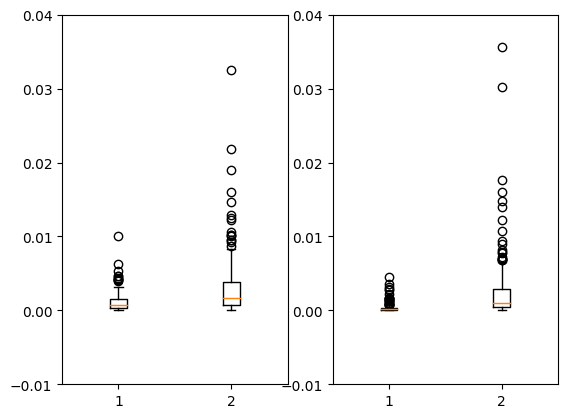

In [26]:
%matplotlib inline

theo_errs = np.zeros((2, x_test.shape[0]))
errs = np.zeros((2, x_test.shape[0]))
for i in range(x_test.shape[0]):
    theo_errs[0,i] = ws.d(m(x_test[i]), preds[0,i,:])**2
    theo_errs[1,i] = ws.d(m(x_test[i]), preds[1,i,:])**2
    errs[0,i] = ws.d(y_test[i], preds[0,i,:])**2
    errs[1,i] = ws.d(y_test[i], preds[1,i,:])**2

plt.subplot(1,2,1)
plt.ylim(-0.01, 0.04)
plt.boxplot(errs.T)
plt.subplot(1,2,2)
plt.ylim(-0.010, 0.04)
plt.boxplot(theo_errs.T)

_e = theo_errs.mean(axis=1); print(_e, _e[0]/_e[1])
_e = errs.mean(axis=1); print(_e, _e[0]/_e[1])


# N=400; s=350; J=20; d=3
# [0.00025194 0.00026428] 0.953284280254688
# [0.00095082 0.00100687] 0.944330134541712


# N=200; s=150; J=20; d=20
# [0.00035953 0.00379374] 0.09477055816174629
# [0.00103223 0.00427651] 0.24137142462410738

# N=200; s=150; J=20; d=3
# [0.00039429 0.00039929] 0.9874933750528989
# [0.00102956 0.00105937] 0.9718606964033686

# N=100; s=80; J=20; d=20
# [0.00101778 0.00340443] 0.2989582234836014
# [0.00170774 0.00417885] 0.4086635187544838

# N=100; s=80; J=20; d=3
# [0.00069322 0.00103881] 0.6673205218115806
# [0.00144751 0.00142333] 1.0169880332104437


In [27]:
fmean = ws.fm(y_train, np.ones(N)/N)
fvar = np.sum([ ws.d(fmean, y_test[i,:])**2 for i in range(N) ])

# N=200; s=150; J=20; d=3
# (0.8607352116938509, 0.8603832277524206)


# N=200; s=150; J=20; d=10
# (0.8602941179000505, 0.6072508545516133)


1 - errs[0,:].sum() / fvar, 1 - errs[1,:].sum() / fvar

(0.8602941179000505, 0.6072508545516133)